In [3]:
%load_ext autoreload
%autoreload 2

from biolearn.data_library import DataLibrary
import pickle
from tqdm import tqdm
import textwrap
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, wilcoxon
from statsmodels.stats.multitest import multipletests
from os.path import basename, splitext, exists
from glob import glob

from computage.utils.data_utils import test_dataset
from computage.configs.datasets_bench_config import *
from computage.benchmarking.benchmarking import EpiClocksBenchmarking

import warnings
warnings.filterwarnings('ignore')

# test call of dataset

In [166]:
gse = 'GSE52588'
data_source = DataLibrary().get(gse)

print(textwrap.fill(data_source.summary, 70))
data=data_source.load()

Down syndrome is characterized by a wide spectrum of clinical signs,
which include cognitive and endocrine disorders and haematological
abnormalities. Although it is well established that the causative
defect of Down syndrome is the trisomy of chromosome 21, the molecular
bases of Down syndrome phenotype are still largely unknown. We used
the Infinium HumanMethylation450 BeadChip to investigate DNA
methylation patterns in whole blood from 29 subjects affected by Down
syndrome (DS), using their healthy relatives as controls (mothers  and
unaffected siblings). This family-based model allowed us to monitor
possible confounding effects on DNA methylation patterns deriving from
genetic and environmental (lifestyle) factors. The identified
epigenetic signature of Down syndrome includes differentially
methylated regions that, although enriched on chromosome 21, interest
most of the other chromosomes and can be functionally linked to the
developmental and haematological defects characteristic 

In [167]:
data_obj = {}
data_obj['data'] = data.dnam
data_obj['meta'] = data.metadata

In [168]:
pickle.dump(data_obj, open(f'data/{gse}.pkl', 'wb'))

In [169]:
#now load it
data_obj = pickle.load(open(f'data/{gse}.pkl', 'rb'))

In [171]:
data_obj['meta']['disease_state']#.value_counts()

id
GSM1272122    Down syndrome
GSM1272123    Down syndrome
GSM1272124    Down syndrome
GSM1272125    Down syndrome
GSM1272126    Down syndrome
                  ...      
GSM1272204          healthy
GSM1272205          healthy
GSM1272206          healthy
GSM1272207          healthy
GSM1272208          healthy
Name: disease_state, Length: 87, dtype: object

# test dataset downloading

In [1]:
import requests
from urllib.parse import urlencode
import os

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/6EKzmWgHWfQhhA'  # link to file

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_url

'https://downloader.disk.yandex.ru/disk/c3497b4318bdb37d31e77c872507055652550449e3a53e42ad020f4553360079/6602bc7e/o-xAw257UInz2E5KCNNYxzrwZIFIEChaHjZ5c8XuVTkQQP5Vu3LX_PfcrbWl_WXMgzctlrPIR5lis-RHW_1Y4w%3D%3D?uid=0&filename=jess.jpg&disposition=attachment&hash=PIh7RkISs8vpRICogGJFgYXo7GoHNggOK3PpICkoZx%2BkzyvR9xvEdnuySuRZLXysq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=image%2Fjpeg&owner_uid=614251127&fsize=3052875&hid=53e1d3b50896254829e1f189ba2f4197&media_type=image&tknv=v2'

In [ ]:
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('jess.jpg', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

In [ ]:
download_url = 'https://disk.yandex.ru/d/UKAe_mXsv2TfVg'
out_file_name = 'jess.txt'

with open(os.path.join(out_file_name), 'wb') as out_stream:
    req = requests.get(download_url, stream=True)
    for chunk in req.iter_content(1024):  # Куски по 1 КБ
        out_stream.write(chunk)

# Benchmarking of published clocks

In [4]:
models_config = {
    "in_library":{
        'Horvathv1':{},
        'Hannum':{},
        'Lin':{},
        'PhenoAge':{},
        'YingCausAge':{},
        'YingDamAge':{},
        'YingAdaptAge':{},
        'Horvathv2':{},
        'HRSInCHPhenoAge':{},
        # 'PEDBE':{},
        # 'GrimAgeV1':{},
        # 'GrimAgeV2':{}
    },
    #each model should have `path` in its dict values (see example)
    #each model should be stored in pickle (.pkl) format
    "new_models":{
        #'my_new_model_name': {'path':/path/to/model.pkl}
        
    }
}

# datasets_config_short = dict(list(datasets_config_old.items())[:3])


In [ ]:
#fill config with new models
pattern = '/tank/projects/computage/checkpoints/*fs3*'
for p in glob(pattern):
    name = splitext(basename(p))[0]
    models_config['new_models'][name] = {'path':p}

In [9]:
# data, meta = pd.read_pickle('/tank/projects/computage/benchmarking/GSE103929.pkl.gz', compression='gzip').values()

In [3]:
datasets_config_short = dict(list(datasets_config_main.items())[-19:-15])
datasets_config_short

{'GSE182991': {'path': '/tank/projects/computage/benchmarking/GSE182991.pkl.gz',
  'conditions': ['HGPS', 'ncLMNA'],
  'test': 'AA2'},
 'GSE214297': {'path': '/tank/projects/computage/benchmarking/GSE214297.pkl.gz',
  'conditions': ['CGL'],
  'test': 'AA2'},
 'GSE43976': {'path': '/tank/projects/computage/benchmarking/GSE43976.pkl.gz',
  'conditions': ['MS'],
  'test': 'AA1'},
 'GSE59685': {'path': '/tank/projects/computage/benchmarking/GSE59685.pkl.gz',
  'conditions': ['AD'],
  'test': 'AA2'}}

In [5]:
bench = EpiClocksBenchmarking(
    models_config=models_config,
    # datasets_config=datasets_config_short,
    datasets_config=datasets_config_main,
    tissue_types='BSB',
    age_limits = [18, 90],
    age_limits_class_exclusions= ['PGS'],
    experiment_prefix='prefinal2',
    delta_assumption = 'normal',
    correction_threshold=0.05,
    save_results=True,
    output_folder='./tmp_bench_results',
    verbose=1
)
bench.run()

9 models will be tested on 61 datasets.


Datasets:   0%|          | 0/61 [00:00<?, ?it/s]

Datasets:   2%|▏         | 1/61 [00:41<41:12, 41.21s/it]

GSE56046:AS - AA2 testing 776 disease versus 339 healthy samples


Datasets:   3%|▎         | 2/61 [00:52<23:14, 23.63s/it]

GSE56581:AS - AA2 testing 127 disease versus 66 healthy samples


Datasets:   5%|▍         | 3/61 [00:52<12:29, 12.92s/it]

GSE62867:IHD - AA1 testing 6 disease samples


Datasets:   7%|▋         | 4/61 [00:58<09:40, 10.19s/it]

GSE69138:CVA - AA1 testing 172 disease samples


Datasets:   8%|▊         | 5/61 [00:59<06:28,  6.94s/it]

GSE107143:AS - AA2 testing 8 disease versus 8 healthy samples


Datasets:  10%|▉         | 6/61 [01:03<05:18,  5.79s/it]

GSE203399:CVA - AA1 testing 118 disease samples


Datasets:  11%|█▏        | 7/61 [01:05<04:08,  4.61s/it]

GSE32148:IBD - AA2 testing 5 disease versus 5 healthy samples


Datasets:  13%|█▎        | 8/61 [01:14<05:09,  5.83s/it]

GSE87640:IBD - AA2 testing 156 disease versus 84 healthy samples


Datasets:  15%|█▍        | 9/61 [01:24<06:26,  7.43s/it]

GSE87648:IBD - AA2 testing 203 disease versus 176 healthy samples


Datasets:  16%|█▋        | 10/61 [01:28<05:20,  6.28s/it]

GSE53840:HIV - AA1 testing 111 disease samples


Datasets:  18%|█▊        | 11/61 [01:30<03:58,  4.77s/it]

GSE53841:HIV - AA1 testing 24 disease samples


Datasets:  20%|█▉        | 12/61 [01:41<05:39,  6.94s/it]

GSE67705:HIV - AA2 testing 189 disease versus 91 healthy samples


Datasets:  21%|██▏       | 13/61 [01:46<04:52,  6.09s/it]

GSE67751:HIV - AA2 testing 23 disease versus 69 healthy samples


Datasets:  23%|██▎       | 14/61 [01:59<06:32,  8.34s/it]

GSE77696:HIV - AA2 testing 261 disease versus 117 healthy samples


Datasets:  25%|██▍       | 15/61 [02:12<07:29,  9.77s/it]

GSE100264:HIV - AA1 testing 386 disease samples


Datasets:  26%|██▌       | 16/61 [02:33<09:52, 13.17s/it]

GSE107080:HIV - AA1 testing 405 disease samples


Datasets:  28%|██▊       | 17/61 [02:50<10:25, 14.22s/it]

GSE117859:HIV - AA1 testing 608 disease samples


Datasets:  30%|██▉       | 18/61 [03:16<12:42, 17.73s/it]

GSE117860:HIV - AA1 testing 529 disease samples


Datasets:  31%|███       | 19/61 [03:19<09:20, 13.33s/it]

GSE140800:HIV - AA1 testing 70 disease samples


Datasets:  33%|███▎      | 20/61 [03:22<07:05, 10.37s/it]

GSE143942:HIV - AA2 testing 61 disease versus 12 healthy samples


Datasets:  34%|███▍      | 21/61 [03:25<05:24,  8.11s/it]

GSE145714:HIV_TB - AA2 testing 6 disease versus 9 healthy samples
GSE145714:TB - AA2 testing 12 disease versus 9 healthy samples


Datasets:  36%|███▌      | 22/61 [03:29<04:20,  6.69s/it]

GSE185389:HIV - AA1 testing 56 disease samples


Datasets:  38%|███▊      | 23/61 [03:31<03:29,  5.51s/it]

GSE185390:HIV - AA1 testing 30 disease samples


Datasets:  39%|███▉      | 24/61 [03:56<06:52, 11.15s/it]

GSE217633:HIV - AA2 testing 368 disease versus 43 healthy samples


Datasets:  41%|████      | 25/61 [04:18<08:43, 14.53s/it]

GSE42861:RA - AA2 testing 354 disease versus 335 healthy samples


Datasets:  43%|████▎     | 26/61 [04:20<06:11, 10.62s/it]

GSE71841:RA - AA2 testing 12 disease versus 12 healthy samples


Datasets:  44%|████▍     | 27/61 [04:21<04:32,  8.01s/it]

GSE99624:OP - AA2 testing 32 disease versus 16 healthy samples


Datasets:  46%|████▌     | 28/61 [04:31<04:37,  8.39s/it]

GSE131989:RA - AA2 testing 230 disease versus 123 healthy samples


Datasets:  48%|████▊     | 29/61 [04:35<03:48,  7.14s/it]

GSE134429:RA - AA2 testing 47 disease versus 17 healthy samples


Datasets:  49%|████▉     | 30/61 [04:40<03:20,  6.47s/it]

GSE137593:OA - AA1 testing 5 disease samples
GSE137593:RA - AA1 testing 43 disease samples


Datasets:  51%|█████     | 31/61 [04:45<03:02,  6.08s/it]

GSE137594:OA - AA1 testing 6 disease samples
GSE137594:RA - AA1 testing 46 disease samples


Datasets:  52%|█████▏    | 32/61 [04:49<02:41,  5.56s/it]

GSE138653:RA - AA1 testing 80 disease samples


Datasets:  54%|█████▍    | 33/61 [04:54<02:30,  5.38s/it]

GSE175364:RA - AA2 testing 8 disease versus 13 healthy samples


Datasets:  56%|█████▌    | 34/61 [05:00<02:26,  5.43s/it]

GSE176168:RA - AA1 testing 113 disease samples


Datasets:  57%|█████▋    | 35/61 [05:03<01:58,  4.57s/it]

GSE228104:RA - AA1 testing 40 disease samples


Datasets:  59%|█████▉    | 36/61 [05:03<01:23,  3.33s/it]

GSE49909:XOB - AA2 testing 9 disease versus 40 healthy samples


Datasets:  61%|██████    | 37/61 [05:03<00:58,  2.42s/it]

GSE56606:T1D - AA2 testing 25 disease versus 61 healthy samples


Datasets:  62%|██████▏   | 38/61 [05:06<00:54,  2.38s/it]

GSE62003:T2D - AA1 testing 58 disease samples


Datasets:  64%|██████▍   | 39/61 [05:07<00:44,  2.02s/it]

GSE193836:XOB - AA2 testing 10 disease versus 11 healthy samples


Datasets:  66%|██████▌   | 40/61 [05:08<00:39,  1.90s/it]

GSE166611:XOB - AA2 testing 11 disease versus 17 healthy samples


Datasets:  67%|██████▋   | 41/61 [05:10<00:35,  1.75s/it]

GSE118468:COPD - AA2 testing 15 disease versus 6 healthy samples


Datasets:  69%|██████▉   | 42/61 [05:14<00:45,  2.41s/it]

GSE131752:WS - AA2 testing 21 disease versus 24 healthy samples


Datasets:  70%|███████   | 43/61 [05:16<00:43,  2.42s/it]

GSE182991:HGPS - AA2 testing 15 disease versus 12 healthy samples


Datasets:  72%|███████▏  | 44/61 [05:18<00:40,  2.39s/it]

GSE214297:CGL - AA2 testing 7 disease versus 9 healthy samples


Datasets:  74%|███████▍  | 45/61 [05:21<00:40,  2.50s/it]

GSE43976:MS - AA1 testing 52 disease samples


Datasets:  75%|███████▌  | 46/61 [05:34<01:25,  5.71s/it]

GSE59685:AD - AA2 testing 40 disease versus 9 healthy samples


Datasets:  77%|███████▋  | 47/61 [06:03<02:55, 12.57s/it]

GSE72774:PD - AA2 testing 287 disease versus 218 healthy samples


Datasets:  79%|███████▊  | 48/61 [06:06<02:04,  9.59s/it]

GSE72776:PD - AA2 testing 46 disease versus 38 healthy samples


Datasets:  80%|████████  | 49/61 [06:08<01:30,  7.51s/it]

GSE103929:MS - AA1 testing 49 disease samples


Datasets:  82%|████████▏ | 50/61 [06:26<01:54, 10.43s/it]

GSE106648:MS - AA2 testing 139 disease versus 139 healthy samples


Datasets:  84%|████████▎ | 51/61 [06:41<01:59, 11.91s/it]

GSE111223:PD - AA2 testing 128 disease versus 131 healthy samples


Datasets:  85%|████████▌ | 52/61 [07:22<03:06, 20.67s/it]

GSE111629:PD - AA2 testing 335 disease versus 236 healthy samples


Datasets:  87%|████████▋ | 53/61 [07:30<02:15, 16.97s/it]

GSE112596:MS - AA1 testing 112 disease samples


Datasets:  89%|████████▊ | 54/61 [07:32<01:26, 12.34s/it]

GSE130029:MS - AA2 testing 20 disease versus 11 healthy samples


Datasets:  90%|█████████ | 55/61 [07:33<00:54,  9.08s/it]

GSE130030:MS - AA2 testing 14 disease versus 14 healthy samples


Datasets:  92%|█████████▏| 56/61 [07:37<00:37,  7.43s/it]

GSE130491:MS - AA1 testing 82 disease samples


Datasets:  93%|█████████▎| 57/61 [07:51<00:37,  9.36s/it]

GSE144858:AD - AA2 testing 93 disease versus 96 healthy samples
GSE144858:MCI - AA2 testing 111 disease versus 96 healthy samples


Datasets:  95%|█████████▌| 58/61 [07:53<00:21,  7.30s/it]

GSE151355:PD - AA1 testing 19 disease samples


Datasets:  97%|█████████▋| 59/61 [08:06<00:17,  8.81s/it]

GSE156994:CJD - AA2 testing 114 disease versus 105 healthy samples


Datasets:  98%|█████████▊| 60/61 [08:13<00:08,  8.48s/it]

GSE219293:MS - AA2 testing 29 disease versus 18 healthy samples


Datasets: 100%|██████████| 61/61 [08:22<00:00,  8.25s/it]


GSE122244:PD - AA2 testing 35 disease versus 34 healthy samples
Compute MedAE metric based on 2785 healthy control samples.


# Metadata descriptive statistics

In [182]:
import seaborn as sns
from matplotlib import pyplot as plt
from computage.utils.data_utils import cond2class
full_meta = pd.concat(bench.datasets_metadata.values(), axis=0)
full_meta['Age'] = full_meta['Age'].astype(float)

full_meta = full_meta[~full_meta['Age'].isna()]
full_meta = full_meta[~full_meta['Condition'].isna()]
full_meta = full_meta[~full_meta['Condition'].isin(['Exclude', 'EA', 'UA', 'OBS', 'MDPS', 'MCI'])]
condition_order = ['HC'] + sorted([c for c in full_meta.Condition.unique() if c not in ['HC']])
full_meta['Gender'] = full_meta['Gender'].map({'M':'Male', 'F':'Female'})
full_meta['Gender'] = full_meta['Gender'].fillna('Unknown')
full_meta['Class'] = ['HC' if c == 'HC' else cond2class([c])[0] for c in full_meta['Condition']]
class_order = ['HC'] + sorted([c for c in full_meta.Class.unique() if c not in ['HC']])
full_meta = full_meta.sort_values('Condition')

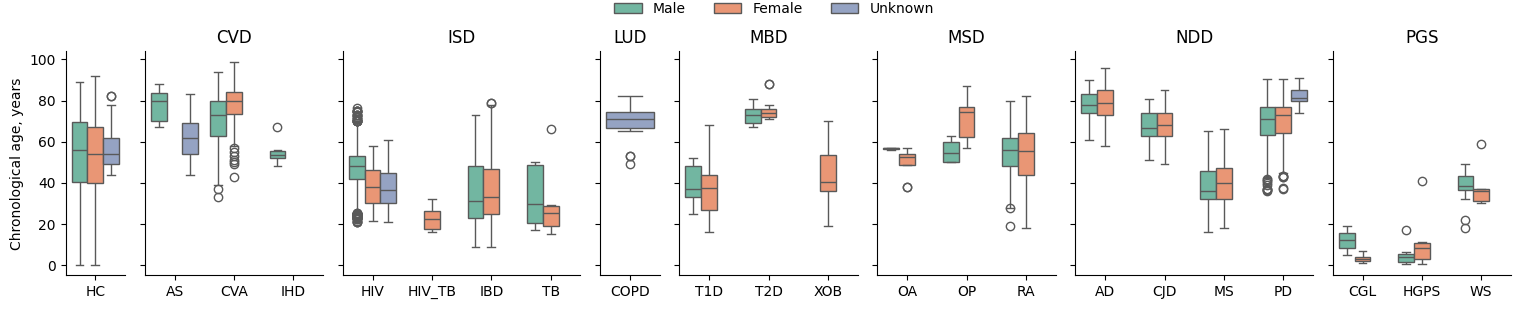

In [187]:
g = sns.FacetGrid(full_meta, col="Class", sharex=False,
                  col_order=class_order,
                  gridspec_kws={"width_ratios":[1, 3, 4, 1, 3, 3, 4, 3]},
                  height=3.0,
				  aspect=0.5
                  )
g.map(sns.boxplot, "Condition", "Age",  "Gender", 
      **{"hue_order":['Male', 'Female', 'Unknown'],
         "palette":sns.color_palette('Set2')
         })
# palette_box = sns.color_palette('Set2')
# palette_swarm = sns.color_palette('Set3')

# g.map(sns.violinplot, "Condition", "Age",  "Gender",
# 		**dict(palette=palette_box, width=0.5, inner=None, cut=0, linewidth=0, native_scale=True))
# g.map(sns.stripplot, "Condition", "Age",  "Gender",
# 		**dict(palette=palette_swarm, linewidth=1, edgecolor='w', size=5, native_scale=True))
# g.map(sns.boxplot, "Condition", "Age",  "Gender",
# 		**dict(fill=False, width=0.3, medianprops={'color': 'k', 'linewidth': 2}, zorder=3,
#                         linewidth=1, color='gray', showfliers=False, showcaps=False, native_scale=True))
		 
g.add_legend(**{'ncol':3, 'loc':[0.40, 0.93]})
g.axes[0][0].set_ylabel('Chronological age, years')

for i in range(len(g.axes[0])):
	g.axes[0][i].set_xlabel('')
	cl = g.axes[0][i].get_title().split('= ')[1]
	if cl != 'HC':
		g.axes[0][i].set_title(f'{cl}')
	else:
		g.axes[0][i].set_title(f'')

plt.tight_layout()
plt.savefig(f'figures/main/age_statistics.pdf', format='pdf', dpi=200)
plt.show()

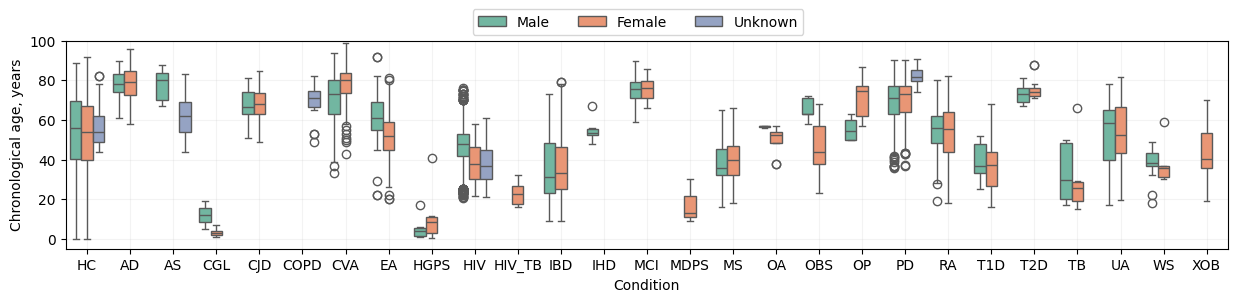

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2.7))
sns.boxplot(full_meta, 
            x='Condition', 
            y='Age', 
            order=condition_order, 
            hue='Gender', 
            hue_order=['Male', 'Female', 'Unknown'],
            palette=sns.color_palette('Set2'),
            ax=ax)
ax.legend(loc=[0.35, 1.03], ncol=3)
ax.set_ylim(-5, 100)
ax.set_ylabel('Chronological age, years')
ax.grid(alpha=0.15)

# AA2 plots

In [27]:
from computage.utils.data_utils import cond2class
import seaborn as sns
from matplotlib import pyplot as plt

df = bench.bench_deltas_AA2
df["Class"] = cond2class([c.split(':')[1] for c in df['Dataset']])

In [ ]:
models = df.Model.unique()
n_cols = len(df.Model.unique())
for cl in df['Class'].unique():
    dfcl = df[df['Class']==cl]
    class_datasets = dfcl.Dataset.unique()
    n_rows = len(class_datasets)
    
    fig, axes = plt.subplots(n_rows, n_cols, 
                             figsize=(n_cols*1.5, n_rows*1.5 + 1),
                             sharey=False, sharex=True, squeeze=False)
    fig.suptitle(f'AA2 - {cl}', fontsize=16, fontweight='bold')
    for i, d in enumerate(class_datasets):
        for j, m in enumerate(models):
            plotdata = dfcl[(dfcl.Model == m) & (dfcl.Dataset == d)]
            pval = bench.bench_results.loc[m, d]
            palette_swarm = ["#FF4C19", "#00BFFF"]
            palette_box = [ "#FFEBE6", "#CCF2FF"]

            x = 'Condition'
            y = 'Delta'
            
            sns.violinplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                            palette=palette_box, width=0.5, inner=None, cut=0, linewidth=0, native_scale=True)
            sns.stripplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                            palette=palette_swarm, linewidth=1, edgecolor='w', size=5, native_scale=True)
            sns.boxplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                        fill=False, width=0.3, medianprops={'color': 'k', 'linewidth': 2}, zorder=3,
                        linewidth=1, color='gray', showfliers=False, showcaps=False, native_scale=True)

            axes[i, j].set_xlabel('')
            axes[i, j].tick_params(axis='x', labelsize=8)
            axes[i, j].tick_params(axis='y', labelsize=8)
            if i == 0:
                axes[0, j].set_title(r'$\bf{{{m}}}$'.format(m=m) + f'\nP-value={round(pval, 3)}', fontsize=9)
            else:
                axes[i, j].set_title(f'P-value={round(pval,3)}', fontsize=9)

            if j != 0:
                axes[i, j].set_ylabel('')
            else:
                axes[i, j].set_ylabel(f'$\Delta$, years\n({d.split(":")[1]},\n{d.split(":")[0]})', fontsize=9)
    
    plt.tight_layout()            
    plt.savefig(f'figures/supplement/AA2-{cl}_boxes_sup.pdf', format='pdf', dpi=250)
    plt.show()
        

# AA1 plots

In [30]:
from computage.utils.data_utils import cond2class
import seaborn as sns
from matplotlib import pyplot as plt

df = bench.bench_deltas_AA1
df["Class"] = cond2class([c.split(':')[1] for c in df['Dataset']])

In [ ]:
models = df.Model.unique()
n_cols = len(df.Model.unique())
for cl in df['Class'].unique():
    dfcl = df[df['Class']==cl]
    class_datasets = dfcl.Dataset.unique()
    n_rows = len(class_datasets)
    
    fig, axes = plt.subplots(n_rows, n_cols, 
                             figsize=(n_cols*1.5, n_rows*1.5 + 1),
                             sharey=False, sharex=True, squeeze=False)
    fig.suptitle(f'AA1 - {cl}', fontsize=16, fontweight='bold')
    for i, d in enumerate(class_datasets):
        for j, m in enumerate(models):
            plotdata = dfcl[(dfcl.Model == m) & (dfcl.Dataset == d)]
            pval = bench.bench_results.loc[m, d]
            palette_swarm = ["#FF4C19", "#00BFFF"]
            palette_box = [ "#FFEBE6", "#CCF2FF"]

            x = 'Condition'
            y = 'Delta'
            
            sns.violinplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                            palette=palette_box, width=0.5, inner=None, cut=0, linewidth=0, native_scale=True)
            sns.stripplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                            palette=palette_swarm, linewidth=1, edgecolor='w', size=5, native_scale=True)
            sns.boxplot(data=plotdata, x=x, y=y, ax=axes[i, j],
                        fill=False, width=0.3, medianprops={'color': 'k', 'linewidth': 2}, zorder=3,
                        linewidth=1, color='gray', showfliers=False, showcaps=False, native_scale=True)

            axes[i, j].set_xlabel('')
            axes[i, j].tick_params(axis='x', labelsize=8)
            axes[i, j].tick_params(axis='y', labelsize=8)
            axes[i, j].axhline(0., color='grey', ls='--')
            if i == 0:
                axes[0, j].set_title(r'$\bf{{{m}}}$'.format(m=m) + f'\nP-value={round(pval, 3)}', fontsize=9)
            else:
                axes[i, j].set_title(f'P-value={round(pval,3)}', fontsize=9)

            if j != 0:
                axes[i, j].set_ylabel('')
            else:
                axes[i, j].set_ylabel(f'$\Delta$, years\n({d.split(":")[1]},\n{d.split(":")[0]})', fontsize=9)
    
    plt.tight_layout()            
    plt.savefig(f'figures/supplement/AA1-{cl}_boxes_sup.pdf', format='pdf', dpi=250)
    plt.show()

In [31]:
full_meta = pd.concat(bench.datasets_metadata.values(), axis=0)
full_meta['Age'] = full_meta['Age'].astype(float)
full_pred = pd.concat(bench.datasets_predictions.values(), axis=0)
delta = full_pred.subtract(full_meta['Age'].values, axis=0)

In [42]:
d = np.array([1, 2, 3])
h = np.array([0, 1, 2, 4])
pd.DataFrame({'Condition':['AAC']*len(d) + ['HC']*len(h), 'delta':np.concatenate([d, h]), 'Model':'1'})

,Condition,delta,Model
0,AAC,1,1
1,AAC,2,1
2,AAC,3,1
3,HC,0,1
4,HC,1,1
5,HC,2,1
6,HC,4,1


In [34]:
delta['CA'] = full_meta['Age'].copy()
delta

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,HRSInCHPhenoAge,CA
GSM1353204,9.076245,16.749812,22.436206,15.812254,15.100894,1.933245,18.969626,10.348259,13.720695,59.0
GSM1353205,-8.748431,9.290235,15.800717,7.932597,-1.992033,-38.410987,39.641414,1.137469,11.829354,63.0
GSM1353206,3.817756,9.492533,22.215876,10.101781,2.066538,-36.038630,29.490701,5.702662,6.590427,71.0
GSM1353207,11.809870,22.453932,31.126803,25.718791,24.009024,-4.670465,30.203064,9.868766,28.721831,72.0
GSM1353208,4.762899,13.455196,18.709505,17.307541,9.710777,-13.106867,29.670529,8.583468,14.425788,48.0
...,...,...,...,...,...,...,...,...,...,...
GSM3462517,5.295495,-9.595412,-6.554066,-3.038721,-52.542426,23.011506,-6.962264,3.355374,2.786835,62.0
GSM3462518,9.689675,-7.246913,-0.440230,-3.932335,-52.753191,15.124008,9.643545,7.825509,1.650750,61.0
GSM3462519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3462520,3.440355,-12.507622,-9.091270,-7.885253,-61.653427,3.317742,-11.285349,0.812927,-4.979718,76.0


In [20]:
absdiff#.dropna()

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,HRSInCHPhenoAge
GSM1353205,8.748431,9.290235,15.800717,7.932597,1.992033,38.410987,39.641414,1.137469,11.829354
GSM1353208,4.762899,13.455196,18.709505,17.307541,9.710777,13.106867,29.670529,8.583468,14.425788
GSM1353211,12.638874,13.124038,25.922454,16.370040,16.813815,1.930881,22.393692,9.426722,14.241453
GSM1353219,6.761893,15.524675,24.678354,13.685479,10.849644,12.992178,32.140035,14.135787,16.730780
GSM1353222,15.214799,17.845153,33.668530,18.653848,9.869171,6.535548,12.326777,10.296207,12.560254
...,...,...,...,...,...,...,...,...,...
GSM3462511,4.800784,23.028724,21.152502,24.778051,72.592555,0.378206,17.954645,11.862420,17.703828
GSM3462513,0.656307,16.243719,14.647126,9.513032,61.734879,1.738046,1.525199,1.927478,4.982136
GSM3462515,14.545584,28.202563,25.869269,25.446233,74.987430,8.441611,19.249805,15.006424,21.077238
GSM3462517,5.295495,9.595412,6.554066,3.038721,52.542426,23.011506,6.962264,3.355374,2.786835


In [8]:
df = hc_pred.copy()
df['CA'] = hc_age.copy()
df['GSE'] = 

In [14]:
bench

In [9]:
df

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,HRSInCHPhenoAge,CA
GSM1353205,54.251569,72.290235,78.800717,70.932597,61.007967,24.589013,102.641414,64.137469,74.829354,63.0
GSM1353208,52.762899,61.455196,66.709505,65.307541,57.710777,34.893133,77.670529,56.583468,62.425788,48.0
GSM1353211,71.638874,72.124038,84.922454,75.370040,75.813815,60.930881,81.393692,68.426722,73.241453,59.0
GSM1353219,63.761893,72.524675,81.678354,70.685479,67.849644,44.007822,89.140035,71.135787,73.730780,57.0
GSM1353222,78.214799,80.845153,96.668530,81.653848,72.869171,56.464452,75.326777,73.296207,75.560254,63.0
...,...,...,...,...,...,...,...,...,...,...
GSM3462511,73.199216,54.971276,56.847498,53.221949,5.407445,77.621794,60.045355,66.137580,60.296172,78.0
GSM3462513,69.656307,52.756281,54.352874,59.486968,7.265121,70.738046,67.474801,67.072522,64.017864,69.0
GSM3462515,65.454416,51.797437,54.130731,54.553767,5.012570,71.558389,60.750195,64.993576,58.922762,80.0
GSM3462517,67.295495,52.404588,55.445934,58.961279,9.457574,85.011506,55.037736,65.355374,64.786835,62.0


In [11]:
!ls -hl tmp_bench_results

total 88K
-rw-rw-r-- 1 dkriukov dkriukov  11K Apr  3 09:59 bench2_published_bench_adj_pvals.csv
-rw-rw-r-- 1 dkriukov dkriukov 4.2K Apr  3 09:59 bench2_published_bench_bools.csv
-rw-rw-r-- 1 dkriukov dkriukov  12K Apr  3 09:59 bench2_published_bench_pvals.csv
-rw-rw-r-- 1 dkriukov dkriukov 8.7K Apr 17 14:31 prefinal0_bench_adj_pvals.csv
-rw-rw-r-- 1 dkriukov dkriukov 5.1K Apr 17 14:31 prefinal0_bench_bools.csv
-rw-rw-r-- 1 dkriukov dkriukov  530 Apr 17 14:31 prefinal0_bench_CA_pred_MAE.csv
-rw-rw-r-- 1 dkriukov dkriukov  13K Apr 17 14:31 prefinal0_bench_pvals.csv
-rw-rw-r-- 1 dkriukov dkriukov  767 Apr 16 14:52 test2_bench_adj_pvals.csv
-rw-rw-r-- 1 dkriukov dkriukov  315 Apr 16 14:52 test2_bench_bools.csv
-rw-rw-r-- 1 dkriukov dkriukov  504 Apr 16 14:52 test2_bench_CA_pred_MAE.csv
-rw-rw-r-- 1 dkriukov dkriukov  769 Apr 16 14:52 test2_bench_pvals.csv


In [20]:
keys = list(bench.datasets_predictions.keys())

In [45]:
k = keys[20]
for k in keys:
    print(k)
    print(bench.datasets_predictions[k].mean().mean())

GSE56046
65.4142860696623
GSE56581
55.13255337182477
GSE62867
31.215732548258
GSE69138
62.47126678961085
GSE107143
57.19305682109346
GSE203399
61.94609151920956
GSE32148
20.731623206433387
GSE87640
35.286675937340405
GSE87648
41.85642104183096
GSE53840
50.79653539049245
GSE53841
46.83137803468343
GSE67705
53.85686111243916
GSE67751
44.02221506354244
GSE77696
49.96474548804203
GSE100264
50.45620166710822
GSE107080
43.28720844178879
GSE117859
50.488792859419036
GSE117860
43.59981965326171
GSE140800
36.642266967190544
GSE143942
28.071588029362857
GSE145714
25.653688703690584
GSE185389
44.78235273123339
GSE185390
37.76696786113916
GSE217633
31.007763191675203
GSE42861
48.61753166953791
GSE71841
37.78540696887688
GSE99624
57.21610846278078
GSE131989
32.58802709740392
GSE134429
52.1182119804742
GSE137593
45.42194524318468
GSE137594
52.63327198459547
GSE138653
35.39955305383512
GSE175364
40.57425293269749
GSE176168
41.51377045469469
GSE228104
47.5018742986105
GSE49909
31.133025221238466
GSE56

In [46]:
data, meta = pd.read_pickle('/tank/projects/computage/benchmarking/GSE56606.pkl.gz', compression='gzip').values()

In [56]:
data.min(1)

GSM1365585    0.000000e+00
GSM1365586    0.000000e+00
GSM1365587    0.000000e+00
GSM1365588    0.000000e+00
GSM1365589    3.660000e-03
                  ...     
GSM1365680   -3.402823e+38
GSM1365681   -3.402823e+38
GSM1365682   -3.402823e+38
GSM1365683   -3.402823e+38
GSM1365684   -3.402823e+38
Length: 100, dtype: float32

In [12]:
# listmodels = glob('/tank/projects/computage/checkpoints/pls*pheno*ultra*')
# listmodels, len(listmodels)

# legacy

In [2]:
# from biolearn.data_library import GeoData
# from biolearn.model_gallery import ModelGallery

# published = False

# gallery = ModelGallery()

# bench_results_AAP = pd.DataFrame()
# bench_results_AA0 = pd.DataFrame()
# datasets_predictions = {}
# for gse, conf in datasets_config.items():
#     #import data
#     path, cond, test = conf.values()
#     dnam, meta = pd.read_pickle(path, compression='gzip').values()
#     data = GeoData(meta, dnam.T)

#     ###Predict datasets and gather predictions
#     #Note that by default clocks will impute missing data.
#     #To change this behavior set the imputation= parameter when getting the clock #???

#     predictions = {}
#     if published:
#         #published clocks prediction
#         keys = list(gallery.model_definitions.keys())
#         for k in tqdm(keys):
#             try:
#                 if gallery.model_definitions[k]['output']=='Age (Years)':
#                     results = gallery.get(k, imputation_method='none').predict(data)
#                     predictions[k] = results['Predicted']
#             except:
#                 print('Oops!')
#                 continue
#     else:
#         #de novo clocks prediction
#         for path in tqdm(listmodels):
#             k = splitext(basename(path))[0]
#             model = pickle.load(open(path, 'rb'))
#             try:
#                 dnam_ = dnam.reindex(columns = list(model.pls.feature_names_in_)).copy()
#             except:
#                 dnam_ = dnam.reindex(columns = list(model.feature_names_in_)).copy()
#                 dnam_ = dnam_.fillna(0.)
            
#             preds_ = model.predict(dnam_)
#             if type(preds_) == np.ndarray:
#                 predictions[k] = pd.Series(preds_, index=dnam.index)
#             else:
#                 predictions[k] = pd.Series(preds_.values, index=dnam.index)
        
#     pred = pd.DataFrame(predictions)
#     datasets_predictions[gse] = pred.copy()
#     #meta filtering
#     no_age_na_indices = meta[~meta['Age'].isna()].index
#     meta = meta.loc[no_age_na_indices]
#     if test == 'AAP':
#         #calculating mann-whitney test for difference in age acceleration between disease and healthy cohorts
#         disease_idx = meta.index[meta['Condition'] == cond]
#         healthy_idx = meta.index[meta['Condition'] == 'HC']
#         print(f'{cond}:{gse} - AAP testing {len(disease_idx)} disease versus {len(healthy_idx)} healthy samples')
#         pvals = {}
#         for col in pred.columns:
#             disease_true = meta.loc[disease_idx, 'Age'].values
#             healthy_true = meta.loc[healthy_idx, 'Age'].values
#             disease_pred = pred.loc[disease_idx, col].values
#             healthy_pred = pred.loc[healthy_idx, col].values
#             disease_delta = disease_pred - disease_true
#             healthy_delta = healthy_pred - healthy_true
#             stat, pval = mannwhitneyu(disease_delta, healthy_delta, alternative='greater')
#             pvals[col] = pval
#         bench_results_AAP[f'{cond}:{gse}:AAP'] = pd.Series(pvals)
#     elif test == 'AA0':
#         #calculating wilcoxon test for positive age (>0) acceleration in disease cohort
#         disease_idx = meta.index[meta['Condition'] == cond]
#         print(f'{cond}:{gse} - AA0 testing {len(disease_idx)} disease samples')
#         pvals = {}
#         for col in pred.columns:
#             disease_true = meta.loc[disease_idx, 'Age'].values
#             disease_pred = pred.loc[disease_idx, col].values
#             disease_delta = disease_pred - disease_true
#             stat, pval = wilcoxon(disease_delta, alternative='greater')
#             pvals[col] = pval
#         bench_results_AA0[f'{cond}:{gse}:AA0'] = pd.Series(pvals)
#     else:
#         NotImplementedError("Only two tests are currently available: ['AAP', 'AA0'].")
    

In [167]:
#dnam, meta = pd.read_pickle(datasets_config['GSE53840']['path'], compression='gzip').values()

In [3]:
# def correction(x):
#     return multipletests(x, method='fdr_bh')[1]

# bench_results = pd.concat([bench_results_AAP, bench_results_AA0], axis=1).dropna(axis=0)
# corrected_results_AAP = bench_results_AAP.T.apply(correction, axis=0).T < 0.05
# corrected_results_AA0 = bench_results_AA0.T.apply(correction, axis=0).T < 0.05
# corrected_results = pd.concat([corrected_results_AAP, corrected_results_AA0], axis=1)

# print(corrected_results.shape)
# corrected_results.sum(axis=1).sort_values(ascending=False)

# bench_results.to_csv('/tank/projects/computage/results/bench_results_pls_pheno_ultra.csv')
# corrected_results.to_csv('/tank/projects/computage/results/bench_results_pls_pheno_ultra.csv')

In [15]:
pd.read_csv('/tank/projects/computage/results/bench_results_pre_noimputation_corrected.csv', index_col=0)#.sum(axis=1).sort_values(ascending=False)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
Horvathv1,True,False,False,False,False,False,False,False
Hannum,True,True,False,False,False,True,True,False
Lin,True,False,False,False,False,True,False,False
PhenoAge,True,True,False,False,False,True,True,True
YingCausAge,True,False,False,False,False,False,False,False
YingDamAge,False,False,False,False,False,False,True,False
YingAdaptAge,True,False,False,False,False,False,False,False
Horvathv2,True,False,False,False,False,False,False,False
PEDBE,True,False,False,False,False,False,False,False
HRSInCHPhenoAge,True,True,False,False,True,True,True,True


In [13]:
pd.read_csv('/tank/projects/computage/results/bench_results_ultrav1_train_pheno_corrected.csv', index_col=0)#.sum(axis=1).sort_values(ascending=False)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
pls1_11_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_7_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_6_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_1_kdm_pheno_ultrav1,True,True,False,False,False,False,False,False
pls1_12_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_6_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_7_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_13_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_10_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_1_pheno_ultrav1,True,True,False,False,False,False,False,False


In [23]:
pd.read_csv('/tank/projects/computage/results/bench_results_kdm_corrected.csv', index_col=0)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
kdm_rse_all_20k,True,True,False,False,False,False,True,False
kdm_rse_forward_20k,False,False,False,False,True,True,False,False


In [84]:
bench_results_logical = bench_results < 0.05
bench_results_logical

In [49]:
#look up at all models
pd.DataFrame(gallery.model_definitions).T

,year,species,tissue,source,output,model
Horvathv1,2013,Human,Multi-tissue,https://genomebiology.biomedcentral.com/articl...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
Hannum,2013,Human,Blood,https://www.sciencedirect.com/science/article/...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ha..."
Lin,2016,Human,Blood,https://www.aging-us.com/article/100908/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Li..."
PhenoAge,2018,Human,Blood,https://www.aging-us.com/article/101414/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ph..."
YingCausAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingDamAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingAdaptAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
Horvathv2,2018,Human,Skin + blood,https://www.aging-us.com/article/101508/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
PEDBE,2019,Human,Buccal,https://www.pnas.org/doi/10.1073/pnas.1820843116,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'PE..."
Zhang_10,2019,Human,Blood,https://www.nature.com/articles/ncomms14617,Mortality Risk,"{'type': 'LinearMethylationModel', 'file': 'Zh..."
